In [22]:
import pandas as pd
from nltk.stem.porter import *
pd.set_option('display.max_colwidth', None)
data = pd.read_csv('en_dataset.csv',usecols = ["HITId","tweet","sentiment","target"])


stemmer = PorterStemmer()
# relabel sentiment as offensive or not offensive. 
# anything but normal is offensive.
def simplifyLabels(label):
    if(label['sentiment'] == "normal"):
        return "inoffensive"
    else:
        return label['target']

data["label"]=data.apply(simplifyLabels, axis=1)
del data['sentiment']
del data['target']

In [23]:
print(data.label.value_counts())

origin                2161
disability            1007
other                  696
inoffensive            661
gender                 588
sexual_orientation     472
religion                62
Name: label, dtype: int64


In [24]:
import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    norm=None,
    max_features=6000,
    ngram_range=(1, 3),
    smooth_idf=False,
    use_idf=True)

In [25]:
vectorized_data = tfidf_vectorizer.fit_transform(data.tweet)

indexed_data = hstack((np.array(range(0,vectorized_data.shape[0]))[:,None], vectorized_data))
vectorized_data.shape

(5647, 6000)

In [26]:
def labelEnc(label):
    return {
        'inoffensive': 0,
        'origin': 1,
        'disability' : 2,
        'gender': 3,
        'sexual_orientation': 4,
        'religion': 5,
        'other': 6
    }[label]
targets = data.label.apply(labelEnc)

In [27]:
#Split into test and train datasets.

from sklearn.model_selection import train_test_split
data_train, data_test, targets_train, targets_test = train_test_split(indexed_data, targets, test_size=0.3, random_state=0)
data_train, data_dev, targets_train, targets_dev = train_test_split(data_train, targets_train, test_size=0.2, random_state=0)
print("Training set:",targets_train.size)
print(targets_train.value_counts())
print("Dev set:",targets_dev.size)
print(targets_dev.value_counts())
print("Test set:",targets_test.size)
print(targets_test.value_counts())

Training set: 3161
1    1221
2     579
6     383
0     369
3     316
4     254
5      39
Name: label, dtype: int64
Dev set: 791
1    305
2    137
6     99
3     93
0     89
4     61
5      7
Name: label, dtype: int64
Test set: 1695
1    635
2    291
6    214
0    203
3    179
4    157
5     16
Name: label, dtype: int64


In [28]:
from sklearn.linear_model import LogisticRegression
# Train LogReg
logreg_clf = LogisticRegression(multi_class="multinomial",max_iter=10000,random_state=0)
logreg_clf.fit(data_train, targets_train)
logreg_clf.score(data_train, targets_train)

0.9889275545713382

In [29]:
from sklearn.svm import LinearSVC
# Train linSVM
linsvm_clf = LinearSVC(C=0.1,multi_class = "ovr",penalty="l2",max_iter=100000,random_state=0)
linsvm_clf.fit(data_train, targets_train)
linsvm_clf.score(data_train, targets_train)

c:\users\noah\.conda\envs\mlgensim37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.8013286934514394

In [30]:
from sklearn.naive_bayes import MultinomialNB
# Train Naive Bayes
naive_bayes_clf = MultinomialNB()
naive_bayes_clf.fit(data_train,targets_train)
naive_bayes_clf.score(data_train, targets_train)

0.8683960771907624

In [31]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
# Train Decision Tree
decision_tree_clf = DecisionTreeClassifier(random_state=0)
decision_tree_clf.fit(data_train,targets_train)
decision_tree_clf.score(data_train, targets_train)

1.0

In [32]:
from sklearn.ensemble import RandomForestClassifier
# Train Random Forest
random_forest_clf = RandomForestClassifier(n_estimators=100,random_state=0)
random_forest_clf.fit(data_train, targets_train)
random_forest_clf.score(data_train, targets_train)

1.0

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def ShowConfusionMatrix(confusionMatrix, name):
    plt.clf()
    plt.imshow(confusionMatrix, interpolation='nearest', cmap=plt.cm.Spectral)
    classNames = ['inoffensive','origin','disability','gender','sexual_orientation','religion', 'other']
    plt.title(name)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    for i in range(7):
        for j in range(7):
            plt.text(j,i, str(confusionMatrix[i][j]))
    plt.gcf()
    plt.savefig(name+".png")
    plt.show()

precision:0.5960097436780697
recall:0.572692793931732
f1:0.5830377119049313


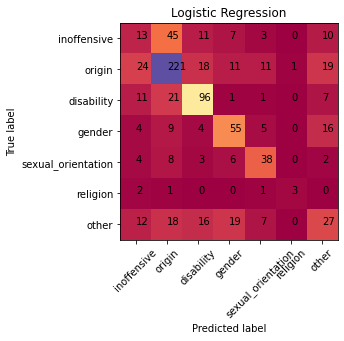

array([0.14606742, 0.72459016, 0.70072993, 0.59139785, 0.62295082,
       0.42857143, 0.27272727])

In [34]:
from sklearn.metrics import confusion_matrix
pred_dev = logreg_clf.predict(data_dev)
print("precision:"+str(precision_score(pred_dev,targets_dev, average='weighted')))
print("recall:"+str(recall_score(pred_dev,targets_dev, average='weighted')))
print("f1:"+str(f1_score(pred_dev,targets_dev, average='weighted')))
confusion=confusion_matrix(targets_dev, pred_dev)
ShowConfusionMatrix(confusion,"Logistic Regression")
confusion.diagonal()/confusion.sum(axis=1)

precision:0.5205952030132178
recall:0.44374209860935526
f1:0.39840072796497145


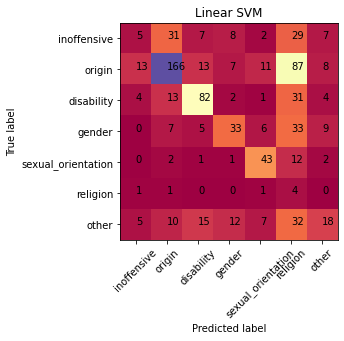

array([0.05617978, 0.5442623 , 0.59854015, 0.35483871, 0.70491803,
       0.57142857, 0.18181818])

In [35]:
pred_dev = linsvm_clf.predict(data_dev)
print("precision:"+str(precision_score(pred_dev,targets_dev, average='weighted')))
print("recall:"+str(recall_score(pred_dev,targets_dev, average='weighted')))
print("f1:"+str(f1_score(pred_dev,targets_dev, average='weighted')))
confusion = confusion_matrix(targets_dev, pred_dev)
ShowConfusionMatrix(confusion, "Linear SVM")
confusion.diagonal()/confusion.sum(axis=1)

precision:0.42410431289658546
recall:0.42604298356510745
f1:0.40196426018965786


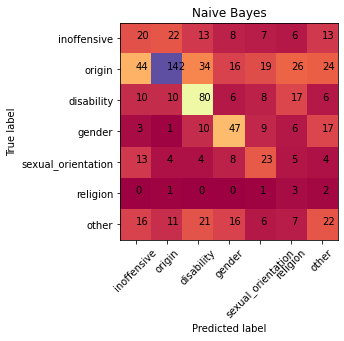

array([0.2247191 , 0.46557377, 0.58394161, 0.50537634, 0.37704918,
       0.42857143, 0.22222222])

In [36]:
pred_dev = naive_bayes_clf.predict(data_dev)
print("precision:"+str(precision_score(pred_dev,targets_dev, average='weighted')))
print("recall:"+str(recall_score(pred_dev,targets_dev, average='weighted')))
print("f1:"+str(f1_score(pred_dev,targets_dev, average='weighted')))
confusion = confusion_matrix(targets_dev, pred_dev)
ShowConfusionMatrix(confusion, "Naive Bayes")
confusion.diagonal()/confusion.sum(axis=1)

precision:0.6166254343755504
recall:0.5739570164348925
f1:0.592977770268412


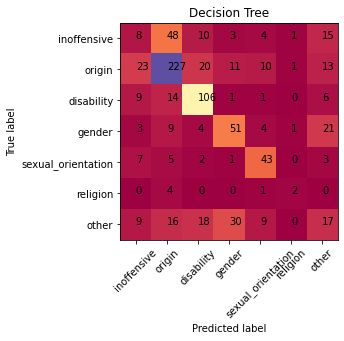

array([0.08988764, 0.7442623 , 0.77372263, 0.5483871 , 0.70491803,
       0.28571429, 0.17171717])

In [37]:
pred_dev = decision_tree_clf.predict(data_dev)
print("precision:"+str(precision_score(pred_dev,targets_dev, average='weighted')))
print("recall:"+str(recall_score(pred_dev,targets_dev, average='weighted')))
print("f1:"+str(f1_score(pred_dev,targets_dev, average='weighted')))
confusion = confusion_matrix(targets_dev, pred_dev)
ShowConfusionMatrix(confusion, "Decision Tree")
confusion.diagonal()/confusion.sum(axis=1)

precision:0.7270000007172525
recall:0.618204804045512
f1:0.662322047622641


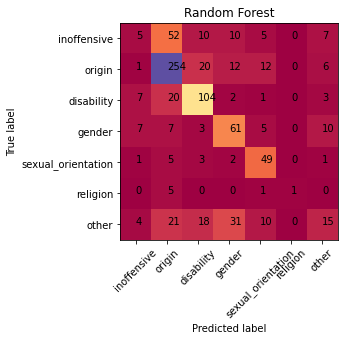

array([0.05617978, 0.83278689, 0.75912409, 0.65591398, 0.80327869,
       0.14285714, 0.15151515])

In [38]:
pred_dev = random_forest_clf.predict(data_dev)
print("precision:"+str(precision_score(pred_dev,targets_dev, average='weighted')))
print("recall:"+str(recall_score(pred_dev,targets_dev, average='weighted')))
print("f1:"+str(f1_score(pred_dev,targets_dev, average='weighted')))
confusion = confusion_matrix(targets_dev, pred_dev)
ShowConfusionMatrix(confusion, "Random Forest")
confusion.diagonal()/confusion.sum(axis=1)